In [1]:
import glob
# matris işlemleri için
import numpy as np
# opencv 
import cv2
# grafik kütüphanesi 
import matplotlib.pylab as plt
# matplotlib grafiklerini jupyter note book üzerinde göstermek için
%matplotlib inline
# rasgele sayı üretimi için
import random

In [2]:
data = glob.glob("/media/phoenix/data/sacrace/collected_data/*.png")

In [3]:
# Toplam kayıt sayımız
len(data)

7383

/media/phoenix/data/sacrace/collected_data/1573895587955_0.0019683837890625_-0.001953125.png


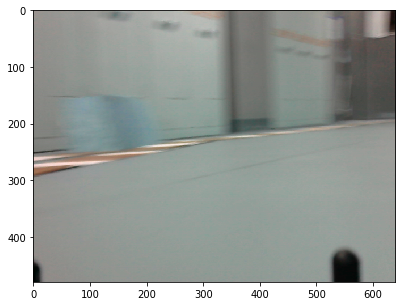

In [7]:
# Kayıt ettğimiz resmin birine bakıyoruz
image = cv2.imread(data[901])
plt.figure(figsize=(15,5))
plt.imshow(image)
print(data[201])

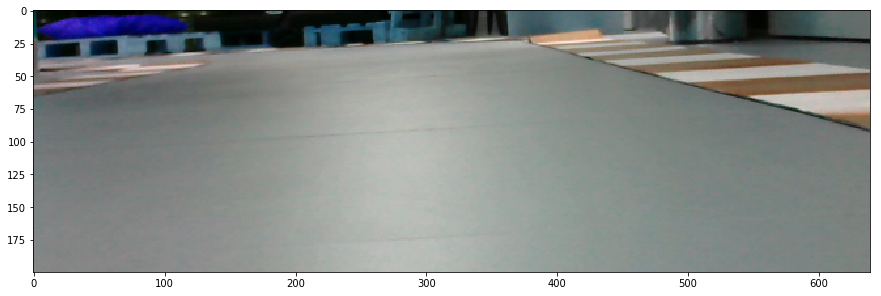

In [11]:
# Resmin her tarafını kullanmamıza gerek yok 
# çeşitli denemeler yaparak kırptığımız alanı görüyoruz
# Uygun gördüğümüz halini ağda kullanacağız
# Biz burda sadece sol görüntüyü  üstten 144 den 300 kadarlık kısmını alıyoruz 
tmp = image[200:400,:672,:]
plt.figure(figsize=(15,5))
plt.imshow(tmp)

In [12]:
labels = np.array([[float(datum.split("_")[2]),float(datum.split("_")[3][:-4])] for datum in data])
print(labels)

[[ 0.25294495 -0.00195312]
 [ 0.15490723 -0.00195312]
 [ 0.25294495  0.00196838]
 ...
 [ 0.04118347 -0.00195312]
 [ 0.03726196  0.35098267]
 [ 0.25294495  0.5       ]]


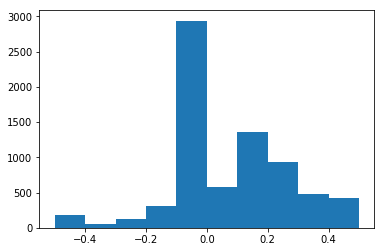

In [13]:
# Verimizdeki açıların dağılımı nasıl diye bir histogram yapıp bakıyoruz
# Dağılımın eşit şekilde olmaması eğitimin de düzgün olmamasına sebep olur
plt.hist(labels[:, 1])
plt.show()

In [16]:
# Veri setindeki açı dağılımını bir paröa düzeltmek için
# sayısı az olan açıdaki kayıtları listeye yeniden ekleyerek 
# daha düzgün hale getirmeye çalışıyoruz
print(labels.shape)
nitem = len(data)
for i in range(nitem):
    if labels[i][1] > 0.2:
        for j in range(0):
            data.append(data[i])
            labels = np.append(labels, [labels[i]], axis=0)    
    if labels[i][1] < -0.15:
        for j in range(7):
            data.append(data[i])
            labels = np.append(labels, [labels[i]], axis=0)   
images=data

(7383, 2)


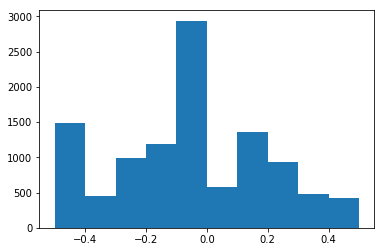

In [17]:
# İlk histgorama göre daga dengeli sayılabilecek bir dağılıma ulaştık
# En doğru çözüm değil ama pratik işe yarar bir alternatif
plt.hist(labels[:, 1])
plt.show()

In [18]:
# Veri setimiz ile ilgili ayarlamalar
# Veri seti küme büyüklüğü batch size
# Verisetinin ne kadarı eğitim ne kadarı test için kullanılacak
# Eğitim %80 , Test %20 
bsize = 8
dlen = len(labels)
splitpoint = int(0.8*dlen)
reindex = list(range(len(labels)))
# Eğtim verisini karıştıryoruz
random.seed(1234)
random.shuffle(reindex)

In [19]:
# Resim üzerinde Rastgele parlaklık değişimi uygulayan bir fonksiyon
# Augmentation function (taken from github)
def augment_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_BGR2HSV) 
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [20]:
# ismi verilen resmi okuyup 
# rastgele olarak %50 sine parlaklık değişimi uygulayan fonksiyonu uygulayıp
# resim matrisini dönem bir fonksiyon

def get_matrix(fname):
    img = cv2.imread(fname)
    #if random.randint(0,1) == 1 :
        #img = augment_brightness(img)        
    return img

In [21]:
# Bütün veriyi hafızaya almamız mümkün değil
# Ek olarak bazen çeşitli değişimler - Augmentation - uygulamakda istiyebiliriz
# python generator ile gerektiğinde veri okunur düzenlenir ve eğitim veya test için 
# sisteme verilir
# alttaki fonksiyonlar bu işi yapar

# Generate data for training
def generate_data():
    i = 0
    while True:
        x = []
        y = []
        for j in range(i,i+bsize):  
            ix = reindex[j]
            img = get_matrix(images[ix])
            lbl = np.array([labels[ix]])
            flip = random.randint(0,1)
            if flip == 1:
                img = cv2.flip(img,1)
                lbl = lbl*-1.0
            x.append(img)
            y.append(lbl)
        x = np.array(x)
        y = np.array(y)       
        yield (x,y)    
        i +=bsize
        if i+bsize > splitpoint:
            i = 0
            
# Generate data for validation                  
def generate_data_val():
    i = splitpoint
    while True:
        x = []
        y = []
        for j in range(i,i+bsize): 
            ix = reindex[j]
            x.append(get_matrix(images[ix]))
            y.append(np.array([labels[ix]]))
        x = np.array(x)
        y = np.array(y)       
        yield (x,y)    
        i +=bsize
        if i+bsize > dlen:
            i = splitpoint

In [22]:
# Keras için gerekenler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, Cropping2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD

Using TensorFlow backend.


tf.estimator package not installed.
tf.estimator package not installed.


In [23]:
# Model based on NVIDIA's End to End Learning for Self-Driving Cars model
# Sıralı bir keras modeli tanılıyoruz
model = Sequential()
# Cropping
# gelen resmin istediğimiz ksımını kırpmak için bu katmanı yazıyoruz
# Cropping2D(cropping((top_crop, bottom_crop), (left_crop, right_crop)))
# aşağıdaki satırda 
# üstten 144 alttan 76 piksel 
# soldan 0 sağdan 672 piksel kırpılıyor
model.add(Cropping2D(cropping=((144,76),(0,0)), input_shape=(480, 640,3)))
# Normalization
# 0 - 255 arası değerler -1 ila 1 arasına çekiliyor
model.add(Lambda(lambda x: (2*x / 255.0) - 1.0))
# Evrişim katmanı (5, 5) lik 24 tane 2 şer piksel kayarak
model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
# Ağın çıkışı burda vectöre çevriliyor
model.add(Flatten())
# Yapay Sinir ağı kısmı
model.add(Dense(100))
# Ağın çıkışı Açı 
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [24]:
# Tanımladığımız ağın yapsı
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 260, 640, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 260, 640, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 318, 24)      1824      
_________________________________________________________________
flatten_1 (Flatten)          (None, 976896)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               97689700  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 97,691,625
Trainable params: 97,691,625
Non-trainable params: 0
________________________________________________________________

In [25]:
# Açı değerlerinide -0.3 ila 0.3 aralığından -1 ila 1 aralığına çekebilmek için 3 ile çarpıyoruz
labels = 3*np.array(labels[:, 1])

In [26]:
# Eğitim esnasında test hata değeri en düşük değeri kaydeden bir fonksiyon
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

In [27]:
# Eğitim fonksiyonu 
hs = model.fit_generator(generate_data(),steps_per_epoch=int(splitpoint/ bsize), validation_data=generate_data_val(),  validation_steps=(dlen-splitpoint)/bsize, epochs=10,callbacks=[model_checkpoint])

Epoch 1/10
1081/1081 [==============================] - 135s 125ms/step - loss: 742.6885 - val_loss: 11.7630
Epoch 2/10
1081/1081 [==============================] - 75s 69ms/step - loss: 21.3342 - val_loss: 2.2208
Epoch 3/10
1081/1081 [==============================] - 75s 70ms/step - loss: 5.8538 - val_loss: 4.8469
Epoch 4/10
1081/1081 [==============================] - 76s 70ms/step - loss: 6.8343 - val_loss: 0.6358
Epoch 5/10
1081/1081 [==============================] - 76s 71ms/step - loss: 1.9310 - val_loss: 1.3239
Epoch 6/10
1081/1081 [==============================] - 77s 71ms/step - loss: 1.1877 - val_loss: 0.8513
Epoch 7/10
1081/1081 [==============================] - 76s 71ms/step - loss: 1.2560 - val_loss: 0.5597
Epoch 8/10
1081/1081 [==============================] - 76s 71ms/step - loss: 0.6273 - val_loss: 0.5838
Epoch 9/10
1081/1081 [==============================] - 76s 71ms/step - loss: 0.3676 - val_loss: 0.3777
Epoch 10/10
1081/1081 [==============================] - 7

['loss', 'val_loss']


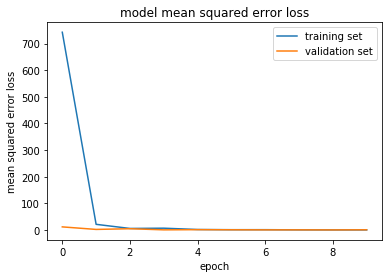

In [28]:

# Eğitim işleminin gidişatını grafik olarak görüyoruz
# Train and validation loss chart
print(hs.history.keys())

plt.plot(hs.history['loss'])
plt.plot(hs.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [29]:
# Eğittiğimiz modeli kaydediyoruz
# Ağ yapsını json olarak
# Ağ parametre değerlerini h5 uzantılı olarak
import json 
# Save model weights and json.
mname = 'sacrace_model'
model.save_weights(mname+'.h5')
model_json  = model.to_json()
with open(mname+'.json', 'w') as outfile:
    json.dump(model_json, outfile)

In [32]:
# rastgele 10 resim seçip modelimiz hesapladığı sonuçla gerçeğine bakıyoruz 
# Eğer sonuçlar iyi ise kullanabiliriz
# Sonuççlar kötüyse eğitim aşamasına dönmemiz lazım
# Compare actual and predicted steering
errors = []
for i in range(len(data)):
    ix = i
    out = model.predict(get_matrix(data[ix]).reshape(1,480,640,3))
    errors.append((labels[ix]-out[0][0])/3)
    if (labels[ix]-out[0][0])/3 >0.3 or (labels[ix]-out[0][0])/3 <-0.3:
        print(labels[ix]/3, ">>>",out[0][0]/3, "///", data[ix])

(-0.001953125, '>>>', 0.4771151940027873, '///', '/media/phoenix/data/sacrace/collected_data/1573895002196_0.0019683837890625_-0.001953125.png')
(-0.0294036865234375, '>>>', -0.4119158585866292, '///', '/media/phoenix/data/sacrace/collected_data/1573895815030_0.0019683837890625_-0.0294036865234375.png')
(-0.001953125, '>>>', 0.2994412382443746, '///', '/media/phoenix/data/sacrace/collected_data/1573894850541_0.0019683837890625_-0.001953125.png')
(-0.001953125, '>>>', 0.45120346546173096, '///', '/media/phoenix/data/sacrace/collected_data/1573895001400_0.0019683837890625_-0.001953125.png')
(-0.4999847412109375, '>>>', -1.5323195457458496, '///', '/media/phoenix/data/sacrace/collected_data/1573895459923_0.0019683837890625_-0.4999847412109375.png')
(0.437255859375, '>>>', 0.09393354256947835, '///', '/media/phoenix/data/sacrace/collected_data/1573894816362_0.2686309814453125_0.437255859375.png')
(-0.5, '>>>', 0.024594247341156006, '///', '/media/phoenix/data/sacrace/collected_data/1573894

(-0.001953125, '>>>', 0.44526878992716473, '///', '/media/phoenix/data/sacrace/collected_data/1573894996582_0.0019683837890625_-0.001953125.png')
(-0.001953125, '>>>', 0.3835900624593099, '///', '/media/phoenix/data/sacrace/collected_data/1573895494940_0.0019683837890625_-0.001953125.png')
(-0.001953125, '>>>', 0.47177624702453613, '///', '/media/phoenix/data/sacrace/collected_data/1573895452292_-0.1313629150390625_-0.001953125.png')
(0.32745361328125, '>>>', -0.03051728755235672, '///', '/media/phoenix/data/sacrace/collected_data/1573895670478_0.194122314453125_0.32745361328125.png')
(0.5, '>>>', 0.08863234519958496, '///', '/media/phoenix/data/sacrace/collected_data/1573895471001_0.2529449462890625_0.5.png')
(-0.001953125, '>>>', 0.47259950637817383, '///', '/media/phoenix/data/sacrace/collected_data/1573894997417_0.0019683837890625_-0.001953125.png')
(-0.001953125, '>>>', 0.3145928382873535, '///', '/media/phoenix/data/sacrace/collected_data/1573895490557_0.0019683837890625_-0.00195

(-0.001953125, '>>>', 0.4717816114425659, '///', '/media/phoenix/data/sacrace/collected_data/1573894999474_0.0019683837890625_-0.001953125.png')
(-0.5, '>>>', -0.1298843522866567, '///', '/media/phoenix/data/sacrace/collected_data/1573894788067_0.3313751220703125_-0.5.png')
(-0.001953125, '>>>', 0.44324131806691486, '///', '/media/phoenix/data/sacrace/collected_data/1573894997550_0.0019683837890625_-0.001953125.png')
(-0.001953125, '>>>', 0.5603508551915487, '///', '/media/phoenix/data/sacrace/collected_data/1573895490354_0.0019683837890625_-0.001953125.png')
(0.48431396484375, '>>>', 0.08640891313552856, '///', '/media/phoenix/data/sacrace/collected_data/1573894815750_0.2529449462890625_0.48431396484375.png')
(-0.001953125, '>>>', 0.7071317831675211, '///', '/media/phoenix/data/sacrace/collected_data/1573895452425_-0.4137115478515625_-0.001953125.png')
(0.437255859375, '>>>', 0.04598761101563772, '///', '/media/phoenix/data/sacrace/collected_data/1573895564870_0.2529449462890625_0.437

(0.2686309814453125, '>>>', -0.04978943864504496, '///', '/media/phoenix/data/sacrace/collected_data/1573894978084_0.0019683837890625_0.2686309814453125.png')
(0.429412841796875, '>>>', 0.12850638230641684, '///', '/media/phoenix/data/sacrace/collected_data/1573894978474_0.037261962890625_0.429412841796875.png')
(-0.001953125, '>>>', -0.34134232997894287, '///', '/media/phoenix/data/sacrace/collected_data/1573895007703_0.0019683837890625_-0.001953125.png')
(0.01373291015625, '>>>', 0.42492250601450604, '///', '/media/phoenix/data/sacrace/collected_data/1573895460324_0.0019683837890625_0.01373291015625.png')
(-0.001953125, '>>>', 0.472939411799113, '///', '/media/phoenix/data/sacrace/collected_data/1573894998346_0.0019683837890625_-0.001953125.png')
(0.5, '>>>', -0.13445623715718588, '///', '/media/phoenix/data/sacrace/collected_data/1573895012415_0.0019683837890625_0.5.png')
(-0.001953125, '>>>', -0.32737888892491657, '///', '/media/phoenix/data/sacrace/collected_data/1573895008631_0.0

(-0.5, '>>>', -0.18206791083017984, '///', '/media/phoenix/data/sacrace/collected_data/1573894788443_0.1666717529296875_-0.5.png')
(-0.001953125, '>>>', -0.6794467767079672, '///', '/media/phoenix/data/sacrace/collected_data/1573895461118_0.0019683837890625_-0.001953125.png')
(0.413726806640625, '>>>', -0.10168955723444621, '///', '/media/phoenix/data/sacrace/collected_data/1573895013611_-0.0058746337890625_0.413726806640625.png')
(-0.001953125, '>>>', 0.4601548910140991, '///', '/media/phoenix/data/sacrace/collected_data/1573894997084_0.0019683837890625_-0.001953125.png')
(-0.4999847412109375, '>>>', -0.009807991484800974, '///', '/media/phoenix/data/sacrace/collected_data/1573894798453_-0.4999847412109375_-0.4999847412109375.png')
(-0.001953125, '>>>', 0.3539888858795166, '///', '/media/phoenix/data/sacrace/collected_data/1573895453089_0.0019683837890625_-0.001953125.png')
(-0.2882232666015625, '>>>', 0.0237110232313474, '///', '/media/phoenix/data/sacrace/collected_data/157389484279

(0.45294189453125, '>>>', -0.045290673772493996, '///', '/media/phoenix/data/sacrace/collected_data/1573894977491_0.0019683837890625_0.45294189453125.png')
(-0.001953125, '>>>', 0.44856945673624676, '///', '/media/phoenix/data/sacrace/collected_data/1573894999871_0.0019683837890625_-0.001953125.png')
(0.5, '>>>', 0.1596312920252482, '///', '/media/phoenix/data/sacrace/collected_data/1573894803099_0.0019683837890625_0.5.png')
(0.4960784912109375, '>>>', 0.07800164818763733, '///', '/media/phoenix/data/sacrace/collected_data/1573894815833_0.2529449462890625_0.4960784912109375.png')
(-0.001953125, '>>>', 0.4576940933863322, '///', '/media/phoenix/data/sacrace/collected_data/1573894996820_0.0019683837890625_-0.001953125.png')
(-0.001953125, '>>>', -0.3051825165748596, '///', '/media/phoenix/data/sacrace/collected_data/1573895815700_0.0019683837890625_-0.001953125.png')
(-0.001953125, '>>>', 0.4698210159937541, '///', '/media/phoenix/data/sacrace/collected_data/1573895003123_0.0019683837890

(-0.001953125, '>>>', 0.47218271096547443, '///', '/media/phoenix/data/sacrace/collected_data/1573894999276_0.0019683837890625_-0.001953125.png')
(-0.001953125, '>>>', 1.1266853014628093, '///', '/media/phoenix/data/sacrace/collected_data/1573895461450_0.0019683837890625_-0.001953125.png')
(-0.5, '>>>', 0.031848845382531486, '///', '/media/phoenix/data/sacrace/collected_data/1573894789094_0.0294189453125_-0.5.png')
(-0.323516845703125, '>>>', 0.015786681324243546, '///', '/media/phoenix/data/sacrace/collected_data/1573894836237_0.1509857177734375_-0.323516845703125.png')
(0.20196533203125, '>>>', 0.5739883979161581, '///', '/media/phoenix/data/sacrace/collected_data/1573895570607_0.2803955078125_0.20196533203125.png')
(0.4647064208984375, '>>>', -0.3013943036397298, '///', '/media/phoenix/data/sacrace/collected_data/1573895015334_-0.4999847412109375_0.4647064208984375.png')
(0.5, '>>>', 0.15636805693308511, '///', '/media/phoenix/data/sacrace/collected_data/1573895470076_0.252944946289

(0.429412841796875, '>>>', 0.08616287509600322, '///', '/media/phoenix/data/sacrace/collected_data/1573895475345_0.241180419921875_0.429412841796875.png')
(0.5, '>>>', -0.15808178981145224, '///', '/media/phoenix/data/sacrace/collected_data/1573895012352_0.0019683837890625_0.5.png')
(0.335296630859375, '>>>', 0.031006882588068645, '///', '/media/phoenix/data/sacrace/collected_data/1573895511716_0.186279296875_0.335296630859375.png')
(0.4725494384765625, '>>>', 0.07434156537055969, '///', '/media/phoenix/data/sacrace/collected_data/1573894840890_0.209808349609375_0.4725494384765625.png')
(-0.001953125, '>>>', -0.33119750022888184, '///', '/media/phoenix/data/sacrace/collected_data/1573895817224_0.2686309814453125_-0.001953125.png')
(-0.001953125, '>>>', 0.5127217372258505, '///', '/media/phoenix/data/sacrace/collected_data/1573894999804_0.0019683837890625_-0.001953125.png')
(0.5, '>>>', 1.2154048283894856, '///', '/media/phoenix/data/sacrace/collected_data/1573895460135_0.00196838378906

(-0.001953125, '>>>', 0.43885453542073566, '///', '/media/phoenix/data/sacrace/collected_data/1573894999406_0.0019683837890625_-0.001953125.png')
(-0.001953125, '>>>', -0.33616475264231366, '///', '/media/phoenix/data/sacrace/collected_data/1573895815230_0.0019683837890625_-0.001953125.png')
(-0.001953125, '>>>', -0.36531070868174237, '///', '/media/phoenix/data/sacrace/collected_data/1573895004914_0.0019683837890625_-0.001953125.png')
(-0.001953125, '>>>', 0.576197346051534, '///', '/media/phoenix/data/sacrace/collected_data/1573895490425_0.0019683837890625_-0.001953125.png')
(-0.5, '>>>', -0.1825500726699829, '///', '/media/phoenix/data/sacrace/collected_data/1573894788524_0.1509857177734375_-0.5.png')
(-0.001953125, '>>>', 0.45964252948760986, '///', '/media/phoenix/data/sacrace/collected_data/1573895002860_0.0019683837890625_-0.001953125.png')
(-0.001953125, '>>>', -0.3586047093073527, '///', '/media/phoenix/data/sacrace/collected_data/1573895815766_0.0019683837890625_-0.001953125.

(-0.001953125, '>>>', -0.373576283454895, '///', '/media/phoenix/data/sacrace/collected_data/1573895012684_0.0019683837890625_-0.001953125.png')
(-0.5, '>>>', 0.029178202152252197, '///', '/media/phoenix/data/sacrace/collected_data/1573894789054_0.178436279296875_-0.5.png')
(-0.001953125, '>>>', 0.3327298363049825, '///', '/media/phoenix/data/sacrace/collected_data/1573895493672_0.0019683837890625_-0.001953125.png')
(-0.001953125, '>>>', 0.42382625738779706, '///', '/media/phoenix/data/sacrace/collected_data/1573894850886_0.1745147705078125_-0.001953125.png')
(0.3470611572265625, '>>>', 0.0363342414299647, '///', '/media/phoenix/data/sacrace/collected_data/1573895538026_0.194122314453125_0.3470611572265625.png')
(-0.001953125, '>>>', 0.5064634482065836, '///', '/media/phoenix/data/sacrace/collected_data/1573895000403_0.0019683837890625_-0.001953125.png')
(-0.001953125, '>>>', -0.3161003589630127, '///', '/media/phoenix/data/sacrace/collected_data/1573895817359_0.01373291015625_-0.00195

(-0.001953125, '>>>', 0.3841207027435303, '///', '/media/phoenix/data/sacrace/collected_data/1573895494269_0.0019683837890625_-0.001953125.png')
(0.4647064208984375, '>>>', 0.12630218267440796, '///', '/media/phoenix/data/sacrace/collected_data/1573895537826_0.194122314453125_0.4647064208984375.png')
(-0.001953125, '>>>', 0.4517536958058675, '///', '/media/phoenix/data/sacrace/collected_data/1573895001466_0.0019683837890625_-0.001953125.png')
(0.476470947265625, '>>>', 0.127650648355484, '///', '/media/phoenix/data/sacrace/collected_data/1573894815624_0.2529449462890625_0.476470947265625.png')
(0.460784912109375, '>>>', 0.02354487031698227, '///', '/media/phoenix/data/sacrace/collected_data/1573894808341_0.0725555419921875_0.460784912109375.png')
(0.4647064208984375, '>>>', 0.04415572683016459, '///', '/media/phoenix/data/sacrace/collected_data/1573895499468_0.1666717529296875_0.4647064208984375.png')
(0.5, '>>>', 0.09931223591168721, '///', '/media/phoenix/data/sacrace/collected_data/

(-0.4999847412109375, '>>>', 2.255919615427653, '///', '/media/phoenix/data/sacrace/collected_data/1573895459967_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 2.255919615427653, '///', '/media/phoenix/data/sacrace/collected_data/1573895459967_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 2.255919615427653, '///', '/media/phoenix/data/sacrace/collected_data/1573895459967_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 2.255919615427653, '///', '/media/phoenix/data/sacrace/collected_data/1573895459967_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 2.255919615427653, '///', '/media/phoenix/data/sacrace/collected_data/1573895459967_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 2.255919615427653, '///', '/media/phoenix/data/sacrace/collected_data/1573895459967_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 2.255919615427653, '///

(-0.4999847412109375, '>>>', 4.422322909037272, '///', '/media/phoenix/data/sacrace/collected_data/1573895460586_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 4.422322909037272, '///', '/media/phoenix/data/sacrace/collected_data/1573895460586_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 4.422322909037272, '///', '/media/phoenix/data/sacrace/collected_data/1573895460586_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 4.422322909037272, '///', '/media/phoenix/data/sacrace/collected_data/1573895460586_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 4.422322909037272, '///', '/media/phoenix/data/sacrace/collected_data/1573895460586_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 4.422322909037272, '///', '/media/phoenix/data/sacrace/collected_data/1573895460586_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 4.422322909037272, '///

(-0.5, '>>>', -0.13776232798894247, '///', '/media/phoenix/data/sacrace/collected_data/1573894787858_0.42156982421875_-0.5.png')
(-0.5, '>>>', -0.13776232798894247, '///', '/media/phoenix/data/sacrace/collected_data/1573894787858_0.42156982421875_-0.5.png')
(-0.5, '>>>', -0.13776232798894247, '///', '/media/phoenix/data/sacrace/collected_data/1573894787858_0.42156982421875_-0.5.png')
(-0.5, '>>>', -0.13776232798894247, '///', '/media/phoenix/data/sacrace/collected_data/1573894787858_0.42156982421875_-0.5.png')
(-0.5, '>>>', -0.13776232798894247, '///', '/media/phoenix/data/sacrace/collected_data/1573894787858_0.42156982421875_-0.5.png')
(-0.5, '>>>', -0.13776232798894247, '///', '/media/phoenix/data/sacrace/collected_data/1573894787858_0.42156982421875_-0.5.png')
(-0.5, '>>>', -0.13776232798894247, '///', '/media/phoenix/data/sacrace/collected_data/1573894787858_0.42156982421875_-0.5.png')
(-0.5, '>>>', -0.18889216581980386, '///', '/media/phoenix/data/sacrace/collected_data/1573894789

(-0.4999847412109375, '>>>', -0.009807991484800974, '///', '/media/phoenix/data/sacrace/collected_data/1573894798453_-0.4999847412109375_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', -0.009807991484800974, '///', '/media/phoenix/data/sacrace/collected_data/1573894798453_-0.4999847412109375_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', -0.009807991484800974, '///', '/media/phoenix/data/sacrace/collected_data/1573894798453_-0.4999847412109375_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', -0.009807991484800974, '///', '/media/phoenix/data/sacrace/collected_data/1573894798453_-0.4999847412109375_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', -0.009807991484800974, '///', '/media/phoenix/data/sacrace/collected_data/1573894798453_-0.4999847412109375_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', -0.009807991484800974, '///', '/media/phoenix/data/sacrace/collected_data/1573894798453_-0.4999847412109375_-0.4999847412109375.png')
(-0.2882232666015625, 

(-0.4999847412109375, '>>>', 0.5700221061706543, '///', '/media/phoenix/data/sacrace/collected_data/1573895459878_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 0.5700221061706543, '///', '/media/phoenix/data/sacrace/collected_data/1573895459878_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 0.5700221061706543, '///', '/media/phoenix/data/sacrace/collected_data/1573895459878_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 0.5700221061706543, '///', '/media/phoenix/data/sacrace/collected_data/1573895459878_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 0.5700221061706543, '///', '/media/phoenix/data/sacrace/collected_data/1573895459878_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 0.5700221061706543, '///', '/media/phoenix/data/sacrace/collected_data/1573895459878_0.0019683837890625_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', 0.570022106170654

(-0.417633056640625, '>>>', -0.09513842066129048, '///', '/media/phoenix/data/sacrace/collected_data/1573894843691_0.209808349609375_-0.417633056640625.png')
(-0.417633056640625, '>>>', -0.09513842066129048, '///', '/media/phoenix/data/sacrace/collected_data/1573894843691_0.209808349609375_-0.417633056640625.png')
(-0.417633056640625, '>>>', -0.09513842066129048, '///', '/media/phoenix/data/sacrace/collected_data/1573894843691_0.209808349609375_-0.417633056640625.png')
(-0.417633056640625, '>>>', -0.09513842066129048, '///', '/media/phoenix/data/sacrace/collected_data/1573894843691_0.209808349609375_-0.417633056640625.png')
(-0.417633056640625, '>>>', -0.09513842066129048, '///', '/media/phoenix/data/sacrace/collected_data/1573894843691_0.209808349609375_-0.417633056640625.png')
(-0.417633056640625, '>>>', -0.09513842066129048, '///', '/media/phoenix/data/sacrace/collected_data/1573894843691_0.209808349609375_-0.417633056640625.png')
(-0.417633056640625, '>>>', -0.09513842066129048, '/

(-0.464691162109375, '>>>', 0.03023078292608261, '///', '/media/phoenix/data/sacrace/collected_data/1573894798849_-0.4058685302734375_-0.464691162109375.png')
(-0.464691162109375, '>>>', 0.03023078292608261, '///', '/media/phoenix/data/sacrace/collected_data/1573894798849_-0.4058685302734375_-0.464691162109375.png')
(-0.464691162109375, '>>>', 0.03023078292608261, '///', '/media/phoenix/data/sacrace/collected_data/1573894798849_-0.4058685302734375_-0.464691162109375.png')
(-0.5, '>>>', -0.1825500726699829, '///', '/media/phoenix/data/sacrace/collected_data/1573894788524_0.1509857177734375_-0.5.png')
(-0.5, '>>>', -0.1825500726699829, '///', '/media/phoenix/data/sacrace/collected_data/1573894788524_0.1509857177734375_-0.5.png')
(-0.5, '>>>', -0.1825500726699829, '///', '/media/phoenix/data/sacrace/collected_data/1573894788524_0.1509857177734375_-0.5.png')
(-0.5, '>>>', -0.1825500726699829, '///', '/media/phoenix/data/sacrace/collected_data/1573894788524_0.1509857177734375_-0.5.png')
(-0

(-0.5, '>>>', -0.10972897211710612, '///', '/media/phoenix/data/sacrace/collected_data/1573894788893_-0.42547607421875_-0.5.png')
(-0.5, '>>>', -0.10972897211710612, '///', '/media/phoenix/data/sacrace/collected_data/1573894788893_-0.42547607421875_-0.5.png')
(-0.5, '>>>', -0.10972897211710612, '///', '/media/phoenix/data/sacrace/collected_data/1573894788893_-0.42547607421875_-0.5.png')
(-0.5, '>>>', -0.10972897211710612, '///', '/media/phoenix/data/sacrace/collected_data/1573894788893_-0.42547607421875_-0.5.png')
(-0.5, '>>>', -0.10972897211710612, '///', '/media/phoenix/data/sacrace/collected_data/1573894788893_-0.42547607421875_-0.5.png')
(-0.5, '>>>', -0.10972897211710612, '///', '/media/phoenix/data/sacrace/collected_data/1573894788893_-0.42547607421875_-0.5.png')
(-0.5, '>>>', -0.10972897211710612, '///', '/media/phoenix/data/sacrace/collected_data/1573894788893_-0.42547607421875_-0.5.png')
(-0.4999847412109375, '>>>', 0.6960522333780924, '///', '/media/phoenix/data/sacrace/colle

(-0.4999847412109375, '>>>', -0.12494902809460957, '///', '/media/phoenix/data/sacrace/collected_data/1573894798387_-0.4999847412109375_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', -0.12494902809460957, '///', '/media/phoenix/data/sacrace/collected_data/1573894798387_-0.4999847412109375_-0.4999847412109375.png')
(-0.4999847412109375, '>>>', -0.12494902809460957, '///', '/media/phoenix/data/sacrace/collected_data/1573894798387_-0.4999847412109375_-0.4999847412109375.png')
(-0.5, '>>>', -0.021136797964572906, '///', '/media/phoenix/data/sacrace/collected_data/1573894789560_0.0019683837890625_-0.5.png')
(-0.5, '>>>', -0.021136797964572906, '///', '/media/phoenix/data/sacrace/collected_data/1573894789560_0.0019683837890625_-0.5.png')
(-0.5, '>>>', -0.021136797964572906, '///', '/media/phoenix/data/sacrace/collected_data/1573894789560_0.0019683837890625_-0.5.png')
(-0.5, '>>>', -0.021136797964572906, '///', '/media/phoenix/data/sacrace/collected_data/1573894789560_0.00196838378906

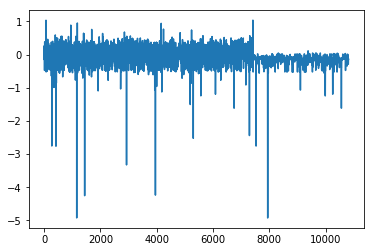

In [33]:
plt.plot(errors)
plt.show()